# 1. Preparação dos Dados (25 pontos)

In [186]:
!pip install pandas

In [187]:
# Biblioteca que permite remover acentos e caracteres especiais
import unidecode

# Biblioteca que permite importar os arquivos do tipo CSV, para dataframes
import pandas as pd

### a. Importação dos arquivos CSV

Abaixo importei todos os arquivos .CSV do dataset "Brazilian E-commerce Public Data ny Olist" utilizando a biblioteca pandas. Cada DataFrame representa uma das entidades principais e seus relacionamentos.

In [189]:
# Pedidos e Detalhes 
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv", sep=",")
df_order_items = pd.read_csv("datasets/olist_order_items_dataset.csv", sep=",")
df_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv", sep=",")
df_reviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv", sep=",")

#Entidades Relacionadas
df_customers = pd.read_csv("datasets/olist_customers_dataset.csv", sep=",")
df_products = pd.read_csv("datasets/olist_products_dataset.csv", sep=",")
df_sellers = pd.read_csv("datasets/olist_sellers_dataset.csv", sep=",")
df_category = pd.read_csv("datasets/product_category_name_translation.csv", sep=",")
df_geolocation = pd.read_csv("datasets/olist_geolocation_dataset.csv", sep=",")

### b. Limpeza dos Dados

Nesta etapa do notebook, realizei o processo de limpeza dos valores em todos os dataframes.
1. Convertir as colunas com valores que continhas datas para o tipo datetime para facilitar análises temporais;
2. Removi valores duplicados, onde foi necessario;
3. No dataframe (df_orders) mantive os valores nulos nas colunas (order_delivered_carrier_date) e (order_delivered_customer_date), pois percebi que a ausencia desses dados, poderia significar que o pedido deve ter sido cancelado;
4. No dataframe (df_products), removi os dados da coluna (product_category_name), pois não são úteis para analises futuras.
5. Realizei o tratamento de strings nos campos textuais, removendo espaços em brancos indevidos antes e depos dos valores. Isso ajuda a evitar erros no momento de realizar joins, agrupamentos ou filtros;
6. Converti dados de das colunas categoricas que estavam no tipo objetos para tipos categoricos para tornar as analises mais corretas;
7. Verifiquei valores invalidos ou inesperados, como: status de pedidos inexisitentes, evitando distorções em analises futuras;
8. Verifiquei se havia inconsistencias de data, na data de entrega antes da compra, assim, evitando conclusões erradas sobre prazos logisticos e melhorando a confiabilidade das metricas temporais (estimativa de entrega dos produtos);
9. Analisei as coordenadas geográficas nulas ou inválidas. Assim, mantendo seguro a precisão em analises geoespaciais e mapas, evitando pontos imprecisos ou não existentes;
10. Verifiquei se a tradução de categorias de produtos PT-BR para EN-US estava funcionando corretamente, para assegurar que o publico que não fala português, entendam os dados contidos na coluna de categorias;
11. Encontrei algumas categorias sem tradução, então adicionei as traduções no df_category.

Verificando a quantidade de valores nulos e duplicados em todos os dataframes

In [193]:
# Verificando valores nulos e duplicatas em todos os DataFrames
dataframes = {
    'orders': df_orders,
    'order_items': df_order_items,
    'payments': df_payments,
    'reviews': df_reviews,
    'customers': df_customers,
    'sellers': df_sellers,
    'products': df_products,
    'category': df_category,
    'geolocation': df_geolocation
}

for name, df in dataframes.items():
    print(f"\n {name.upper()}")
    print("Quantidade de linhas com valores nulos:\n", df.isnull().sum())
    print("Linhas com valores duplicados:", df.duplicated().sum())


 ORDERS
Quantidade de linhas com valores nulos:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Linhas com valores duplicados: 0

 ORDER_ITEMS
Quantidade de linhas com valores nulos:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Linhas com valores duplicados: 0

 PAYMENTS
Quantidade de linhas com valores nulos:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
Linhas com valores duplicados: 0

 REVIEWS
Quantidade de linhas com valores nulos:
 review_id                      0
order_id    

Convertendo as colunas de data para datetime, serve para podermos utilizar análises temporais mais eficazes.

In [195]:
colunas_data = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']
df_orders[colunas_data] = df_orders[colunas_data].apply(pd.to_datetime)

# Nenhuma coluna precisa ser preenchida com média ou mediana, pois datas ausentes em (approved ou delivered) podem representar cancelamentos dos pedidos.

# ### removendo valores duplicados dos dataframes ###

# removendo linhas duplicadas de orders
df_orders.drop_duplicates(inplace=True)
# removendo linhas duplicadas de order_items
df_order_items.drop_duplicates(inplace=True)
# removendo linhas duplicadas de payments
df_payments.drop_duplicates(inplace=True)

# Converter colunas de data do dataframa reviews
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
df_reviews['review_answer_timestamp'] = pd.to_datetime(df_reviews['review_answer_timestamp'])
# removendo linhas duplicadas de reviews
df_reviews.drop_duplicates(inplace=True)

# removendo linhas duplicadas de customers
df_customers.drop_duplicates(inplace=True)
# removendo linhas duplicadas de sellers
df_sellers.drop_duplicates(inplace=True)

# Já que sabemos que existem linhas nulas no dataframe df_products, então teremos que usar uma estageria de manter ou remover os nulos
# isso vai depender de como nos iremos utilizar os dados futuramente.

# Verificar colunas com nulos do dataframe df_products. Retorna um valor boleano True or False. E soma a quantidade de dados nulos.
print(df_products.isnull().sum())

# Removemos do dataframe df_products todas as linhas que têm valor nulo apenas na coluna product_category_name
# Esse processo é importante para análises por categoria. Manter valores nulos nela pode atrapalhar agregações e visualizações.
df_products.dropna(subset=['product_category_name'], inplace=True)

# Removemos todas as linhas duplicadas da tabela df_products, pois o pandas considera como duplicadas as linhas que possuem valores iguais em todas as colunas.
df_products.drop_duplicates(inplace=True)
# removendo linhas duplicadas de category
df_category.drop_duplicates(inplace=True)
# Geolocation pode ter duplicatas porque existem várias entradas por cidade
df_geolocation.drop_duplicates(inplace=True)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


Verificando as conversões

In [197]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Tratamento de Strings

In [199]:
# Essa função, faz o tratamento de remoção de espaços em brancos nas colunas do tipo string.
def remover_espacos(df):
    colunas_str = df.select_dtypes(include = 'object').columns
    df[colunas_str] = df[colunas_str].apply(lambda x: x.str.strip())
    return df

# Aplicar nos dataframes
df_orders = remover_espacos(df_orders)
df_order_items = remover_espacos(df_order_items)
df_payments = remover_espacos(df_payments)
df_reviews = remover_espacos(df_reviews)
df_customers = remover_espacos(df_customers)
df_sellers = remover_espacos(df_sellers)
df_products = remover_espacos(df_products)
df_category = remover_espacos(df_category)
df_geolocation = remover_espacos(df_geolocation)


In [200]:
# Exemplo para evitar conflitos entre nomes de cidades.
df2 = df_sellers[["seller_city", "seller_state"]]
df2

,seller_city,seller_state
0,campinas,SP
1,mogi guacu,SP
2,rio de janeiro,RJ
3,sao paulo,SP
4,braganca paulista,SP
...,...,...
3090,sarandi,PR
3091,palhoca,SC
3092,sao paulo,SP
3093,pelotas,RS


Verificando os tipos de inconsistencias. Para isso, vamos verificar se os tipos das colunas IDs e colunas categóricas, estão corretas. Então convertemos as colunas de categorias para o tipo category e verificamos os valores inválidos ou não esperados nessas colunas.

In [202]:
# Convertendo 
category_columns = ['order_status', 'payment_type', 'review_score',
               'product_category_name', 'customer_state', 'seller_state']

for coluna in category_columns:
    for df in [df_orders, df_payments, df_reviews, df_products, df_customers, df_sellers]:
        if coluna in df.columns:
            df[coluna] = df[coluna].astype('category')
            

Verificando a quantidade de valores invalidos ou inesperados das colunas categoricas

In [204]:
# Verificando a quantidade de valores invalidos ou inesperados das colunas categoricas
print("###### orders ######\n")
print(df_orders['order_status'].value_counts())
print("\n###### payments ######\n")
print(df_payments['payment_type'].value_counts())
print("\n###### reviews ######\n")
print(df_reviews['review_score'].value_counts())

###### orders ######

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

###### payments ######

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

###### reviews ######

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64


Verificando colunas que contem valores zero, mas não deveriam.
Penso em filtrar se parecerem inválidos, ou manter caso forem pedidos gratuitos ou testes.

In [206]:
print(df_payments[df_payments['payment_value'] == 0])

                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  

Verificando se existem datas inconsistens de entrega antes da data de compra ou aprovação das ordens produtos.

In [208]:
df_orders[df_orders['order_delivered_customer_date'] < df_orders['order_purchase_timestamp']]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Verificando se existem localizações inválidas (geolocalização). Verificando se há latitudes/longitudes muito discrepantes ou iguais a zero.

In [210]:
df_geolocation.query("geolocation_lat < -90 or geolocation_lat > 90 or geolocation_lng < -180 or geolocation_lng > 180")
df_geolocation.query("geolocation_lat == 0 or geolocation_lng == 0")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state


Verificando se a cobertura da tradução dos produtos sem categorias. Já que removemos os valores nulos da coluna (product_category_name) do dataframe (df_products) anteriormente. Agora vamos verificar se a tradução do dataframe (product_category_name_translation) esta funcionando corretamente para o PT-BR, no dataframe (df_products).

In [212]:
df_bol = df_products[~df_products['product_category_name'].isin(df_category['product_category_name'])]
df_bol_2 = df_bol[["product_id", "product_category_name"]]
df_bol_2

,product_id,product_category_name
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos


Foram encontrados 2 classificações de categorias em (df_products) que não existem no dataframe de tradução (df_category).
Para corrigir isso, vamos adicionar essas ambas categorias no (df_category).

In [214]:
df_category

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


Adicionando ambas categorias no (df_category).

In [216]:
novas_categorias = pd.DataFrame({
    'product_category_name': ['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
    'product_category_name_english': ['gaming_pc', 'portable_kitchen']
})

df_category = pd.concat([df_category, novas_categorias], ignore_index=True)

In [217]:
df_category

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,pc_gamer,gaming_pc


Vamos consultar novamente o dataframe df_product, e podemos perceber que todas as categorias estão com tradução.

In [219]:
df_bol = df_products[~df_products['product_category_name'].isin(df_category['product_category_name'])]
df_bol_2 = df_bol[["product_id", "product_category_name"]]
df_bol_2

,product_id,product_category_name


### c. Normalização dos Data Frames

Nessa etapa do desafio, realizei a padronização e consistência das colunas dos DataFrames. Realizei etapas que não tinha executado anterior mente na etapa de limpeza de dados.

1. Padronizei os nomes das colunas para o snake_case, minuscula, sem espaços e sem acentos;
2. Verificação de colunas categóricas e conversão para formato consistente;
3. Converti de colunas numéricas com tipo inadequado (price, freight_value) para o tipo float;
4. Padronização de nomes de categorias de produtos traduzidas;
5. Normalizei as colunas datatime para string, pois o sqlite não aceita o tipo de dados como datatime.

Como algumas colunas podem ter letras maiusculas ou inconsistentes. Então vamos padronizar os seus nomes aplicando a normalizaçao snake_case.

In [223]:
def normalizar_nomes_colunas(df):
    df.columns = (
        df.columns
        .str.strip()                      # Remove espaços no início/fim do nome da coluna (isso foi feito anteriormente, mas vamos reforçar)
        .str.lower()                      # Converte todas as letras dos valores para caracteres minúsculas
        .str.replace(' ', '_')            # Substitui espaços por underline ( _ )
        .str.replace('-', '_')            # Substitui hífens por underline ( _ )
        .map(unidecode.unidecode)         # Remove caracteres especiais e acentos
    )
    return df

# criação de uma lista com todos os dataframes a serem normalizados
dfs = [df_orders, df_order_items, df_customers, df_geolocation, df_payments,
       df_reviews, df_products, df_sellers, df_category]

# aplicando a normalização em todos eles
df_orders, df_order_items, df_customers, df_geolocation, df_payments, \
df_reviews, df_products, df_sellers, df_category = [normalizar_nomes_colunas(df) for df in dfs]

In [224]:
df_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


Agora vamos normalizar os textos categóricos, como: cidades, estados, categorias e etc dos dataframes que são composto por esses valores. Nesse processo tratei os nomes das cidades em minusculos e as siglas em maiusculos.

In [226]:
# .str.lower() --> coloca as strings tudo em Minusculos
# .str.upper() --> coloca as strings tudo em Maiusculos

df_customers['customer_city'] = df_customers['customer_city'].str.lower()
df_customers['customer_state'] = df_customers['customer_state'].str.upper()
df_sellers['seller_city'] = df_sellers['seller_city'].str.lower()
df_sellers['seller_state'] = df_sellers['seller_state'].str.upper()

Verificando a normalização do dataframe (df_customers).

In [228]:
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


Verificando a normalização do dataframe (df_sellers).

In [230]:
df_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


Vamor normalizar colunas numericas do dataframe (df_order_items) que podem estar com valores de strings, estão vamos normalizar para que elas recebam valores somente inteiros ou floats

In [232]:
# pd.to_numeric() converte coolunas para tipo float ou int, depedento de como a string esta informada.
# errors='coerce' transforma valores com anomalias em NaN, evitando erro de codigo.

df_order_items['price'] = pd.to_numeric(df_order_items['price'], errors='coerce')
df_order_items['freight_value'] = pd.to_numeric(df_order_items['freight_value'], errors='coerce')

Verificando os tipos após conversão.

In [234]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Vamos agora padronizar o dataframe df_category. É interessante garantir que as traduções estejam limpas e minúsculas para melhor analises futuras.

In [236]:
# Transformando todas as string em minusculos
df_category['product_category_name'] = df_category['product_category_name'].str.lower()
df_category['product_category_name_english'] = df_category['product_category_name_english'].str.lower()

# Substituir strings com espaços por underlines
df_category['product_category_name_english'] = df_category['product_category_name_english'].str.replace(' ', '_')

# Remover acentos e caracteres especiais das strings
df_category['product_category_name'] = df_category['product_category_name'].apply(unidecode.unidecode)
df_category['product_category_name_english'] = df_category['product_category_name_english'].apply(unidecode.unidecode)

Agora vamos normalizar as colunas que são datetime, para string. Pois o SQLite não reconhece tipos datetime. Então criei uma função generica.

In [238]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  category      
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), object(4)
memory usage: 4.6+ MB


In [239]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  category      
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2)
memory usage: 5.4+ MB


In [240]:
# Função genérica
def converter(df, colunas_datetime):
    for col in colunas_datetime:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df

# Colunas dos dataflamers
date_orders = [
    'order_delivered_carrier_date',
    'order_approved_at',
    'order_delivered_customer_date',
    'order_purchase_timestamp',
    'order_estimated_delivery_date'
]

date_reviews = [
    'review_creation_date',
    'review_answer_timestamp'
]

df_orders = converter(df_orders, date_orders)
df_reviews = converter(df_reviews, date_reviews)

In [241]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   order_id                       99441 non-null  object  
 1   customer_id                    99441 non-null  object  
 2   order_status                   99441 non-null  category
 3   order_purchase_timestamp       99441 non-null  object  
 4   order_approved_at              99441 non-null  object  
 5   order_delivered_carrier_date   99441 non-null  object  
 6   order_delivered_customer_date  99441 non-null  object  
 7   order_estimated_delivery_date  99441 non-null  object  
dtypes: category(1), object(7)
memory usage: 5.4+ MB


In [242]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   review_id                99224 non-null  object  
 1   order_id                 99224 non-null  object  
 2   review_score             99224 non-null  category
 3   review_comment_title     11568 non-null  object  
 4   review_comment_message   40977 non-null  object  
 5   review_creation_date     99224 non-null  object  
 6   review_answer_timestamp  99224 non-null  object  
dtypes: category(1), object(6)
memory usage: 4.6+ MB


### d. Criar um modelo relacional e conectar as tabelas adequadamente

Nesta etapa do desafio eu realizei:
1. Importação da biblioteca Sqlite3;
2. Criação do banco de dados chamado (ecommerce.db);
3. Estabeleci uma conexão com o banco de dados;
4. Inseri as tabelas no banco de dados;
5. Estabeleci devidamente o modelo relacional com chaves primarias e estrangeiras;
6. Verifiquei se as tabelas realmente foram criadas de forma correta;
7. Verifiquei sua estrutura e ações como: exclusão em cascata, e restrições de não ter dados em brancos (not-null).

Importando a biblioteca Sqlite3

In [246]:
# Importando a biblioteca do sqlite3
import sqlite3

Criando o banco de dados com o Sqlite3 e realizando coneção

In [248]:
# Criacão do banco de dados sqlite e estabelecendo conexão com o banco de dados.
conn = sqlite3.connect("ecommerce.db")
cursor = conn.cursor()

# comando para encerrar a conexão com o banco de dados --> conn.close()

Inserindo os dataframes no banco de dados.

In [250]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS customers (
    customer_id TEXT PRIMARY KEY,
    customer_unique_id TEXT,
    customer_zip_code_prefix INTEGER,
    customer_city TEXT,
    customer_state TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    product_id TEXT PRIMARY KEY,
    product_category_name TEXT,
    product_name_lenght REAL,
    product_description_lenght REAL,
    product_photos_qty INTEGER,
    product_weight_g REAL,
    product_length_cm REAL,
    product_height_cm REAL,
    product_width_cm REAL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_items (
    order_id TEXT,
    order_item_id INTEGER,
    product_id TEXT,
    seller_id TEXT,
    shipping_limit_date TEXT,
    price REAL,
    freight_value REAL,
    PRIMARY KEY (order_id, order_item_id),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id),
    FOREIGN KEY (seller_id) REFERENCES sellers(seller_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS sellers (
    seller_id TEXT PRIMARY KEY,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_payments (
    order_id TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL,
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_reviews (
    review_id TEXT KEY,
    order_id TEXT,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS geolocation (
    geolocation_zip_code_prefix INTEGER,
    geolocation_lat REAL,
    geolocation_lng REAL,
    geolocation_city TEXT,
    geolocation_state TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS product_category_name_translation (
    product_category_name TEXT PRIMARY KEY,
    product_category_name_english TEXT
);
""")

# Salvando as alterações
conn.commit()

Verificando se a inserção dos dataframes realmente funcionou.

In [252]:
!sqlite3 ecommerce.db ".tables"

customers                          order_reviews                    
geo_por_cep                        orders                           
geolocation                        product_category_name_translation
order_items                        products                         
order_payments                     sellers                          


Ok, esta tudo certo. Agora vamos verificar a estrura das tabelas. Chaves primarias (PK), Estrangeiras (FK) e ações como exclusão em cascata dos dados e se aceita as colunas das tabelas sem dados ou não.

In [254]:
# Lista das tabelas que desejo verificar

verificacao = [
    "order_items", "order_payments", "order_reviews", "products",
    "orders", "customers", "sellers", "geolocation", 
    "product_category_name_translation"
]

# Função para listar colunas e detalhes de uma tabela
def listar_colunas(nome_tabela):
    print(f"\n##################################  {nome_tabela}  #####################################")
    print(f"\nInformacoes da tabela:")
    # PRAGMA table_info() serve para obter os detalhes das colunas
    cursor.execute(f"PRAGMA table_info({nome_tabela});")
    colunas = cursor.fetchall()
    for coluna in colunas:
        print(f"Coluna: {coluna[1]}, ||Tipo: {coluna[2]}||, ||Not Null: {coluna[3]}||, ||PK: {coluna[5]}||")

# Função para mostrar foreign keys
def mostrar_chaves_FK(nome_tabela):
    cursor.execute(f"PRAGMA foreign_key_list({nome_tabela});")
    foreign_key = cursor.fetchall()
    if foreign_key:
        print("\nChaves estrangeiras:")
        for fk in foreign_key:
            print(f"[De '{fk[3]}' -> '{fk[2]}.{fk[4]}'] | <<on update: {fk[5]}>> << on delete: {fk[6]}>>")
    else:
        print("\nChaves estrangeiras:\nSem chaves estrangeiras definidas.")

# Verifica se cada tabela existe e mostra sua estrutura
for tabela in verificacao:
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{tabela}';")
    resultado = cursor.fetchone()
    if resultado:
        listar_colunas(tabela)
        mostrar_chaves_FK(tabela)
        
    else:
        print(f"\nTabela '{tabela}' não encontrada na base de dados.")


##################################  order_items  #####################################

Informacoes da tabela:
Coluna: order_id, ||Tipo: TEXT||, ||Not Null: 0||, ||PK: 1||
Coluna: order_item_id, ||Tipo: INTEGER||, ||Not Null: 0||, ||PK: 2||
Coluna: product_id, ||Tipo: TEXT||, ||Not Null: 0||, ||PK: 0||
Coluna: seller_id, ||Tipo: TEXT||, ||Not Null: 0||, ||PK: 0||
Coluna: shipping_limit_date, ||Tipo: TEXT||, ||Not Null: 0||, ||PK: 0||
Coluna: price, ||Tipo: REAL||, ||Not Null: 0||, ||PK: 0||
Coluna: freight_value, ||Tipo: REAL||, ||Not Null: 0||, ||PK: 0||

Chaves estrangeiras:
[De 'seller_id' -> 'sellers.seller_id'] | <<on update: NO ACTION>> << on delete: NO ACTION>>
[De 'product_id' -> 'products.product_id'] | <<on update: NO ACTION>> << on delete: NO ACTION>>
[De 'order_id' -> 'orders.order_id'] | <<on update: NO ACTION>> << on delete: NO ACTION>>

##################################  order_payments  #####################################

Informacoes da tabela:
Coluna: order_id, ||T

# lembrar de apagar o comando abaixo thiago.

cursor.execute("DROP TABLE IF EXISTS order_items;")
cursor.execute("DROP TABLE IF EXISTS order_payments;")
cursor.execute("DROP TABLE IF EXISTS order_reviews ;")
cursor.execute("DROP TABLE IF EXISTS orders;")
cursor.execute("DROP TABLE IF EXISTS sellers;")
cursor.execute("DROP TABLE IF EXISTS geolocation;")
cursor.execute("DROP TABLE IF EXISTS product_category_name_translation;")
cursor.execute("DROP TABLE IF EXISTS customers;")
cursor.execute("DROP TABLE IF EXISTS products;")
conn.commit()

Importando os dados dos dataframes para as tabelas do banco de dados

In [258]:
# Função para inserir dados de um dataframe em uma tabela
def inserir_dados(df, tabela):
    # Monta o comando INSERT com placeholders para cada coluna
    placeholders = ', '.join(['?'] * len(df.columns))
    sql = f'INSERT INTO {tabela} ({", ".join(df.columns)}) VALUES ({placeholders})'
    
    # Converte os dados do dataframe para lista de tuplas
    dados = [tuple(x) for x in df.to_numpy()]
    
    # Executa o comando para múltiplos registros
    cursor.executemany(sql, dados)
    conn.commit()
    print(f'{len(dados)} registros inseridos na tabela {tabela}.')

# Inserindo dados em cada tabela, seguindo a ordem lógica para respeitar as chaves estrangeiras
inserir_dados(df_category, 'product_category_name_translation')
inserir_dados(df_customers, 'customers')
inserir_dados(df_sellers, 'sellers')
inserir_dados(df_products, 'products')
inserir_dados(df_geolocation, 'geolocation')
inserir_dados(df_orders, 'orders')
inserir_dados(df_order_items, 'order_items')
inserir_dados(df_payments, 'order_payments')
inserir_dados(df_reviews, 'order_reviews')

73 registros inseridos na tabela product_category_name_translation.
99441 registros inseridos na tabela customers.
3095 registros inseridos na tabela sellers.
32341 registros inseridos na tabela products.
738332 registros inseridos na tabela geolocation.
99441 registros inseridos na tabela orders.
112650 registros inseridos na tabela order_items.
103886 registros inseridos na tabela order_payments.
99224 registros inseridos na tabela order_reviews.


# 2. Análise Exploratória de Dados (25 pontos)

In [260]:
import matplotlib.pyplot as plt

### a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

Essa pergunta tem como objetivo identificar como os pedidos variam ao longo do tempo, e se há sazonalidade (picos ou quedas de vendas)
em periodos especificos do ano.

Para isso, trabalhei com a tabela orders onde são registradas todas as informações do pedido, status e datas. 
1. Realizei um SELECT para extrai temporariamente as informações da coluna (order_purchase_timestamp) da tabela (orders), assim, extraindo o ano e mês da data da compra do pedido;
2. Utilizei o COUNT para contar através dos ids das ordens (order_id) quantos pedidos foram realizados em cada mês;
3. Realizei o agrupamento dos dados por mês;
4. Ordenei de forma cronologia as informações do mês;
5. Uma vez esse dado extraido, agrupado e ordenado, converti novamente para o tipo datetime, para garantir a plotagem gráfica correta dessa informação no eixo do tempo;
6. Para plotagem gráfica, optei por utilziar o gráfico de linha. Pois esse tipo de gráfico é ideal para representar séries temporais, pois permite visualizar facilmente a evolução dos dados ao decorrer do periodo. As linhas conectadas por pontos, ajudam a observar tendências, padrões sazonais e variações mensais de forma mais intuitiva. Sendo assim, esse tipo em nosso contexto atual, facilita a identificação de periodos com picos das vendas e quedas da demanda.

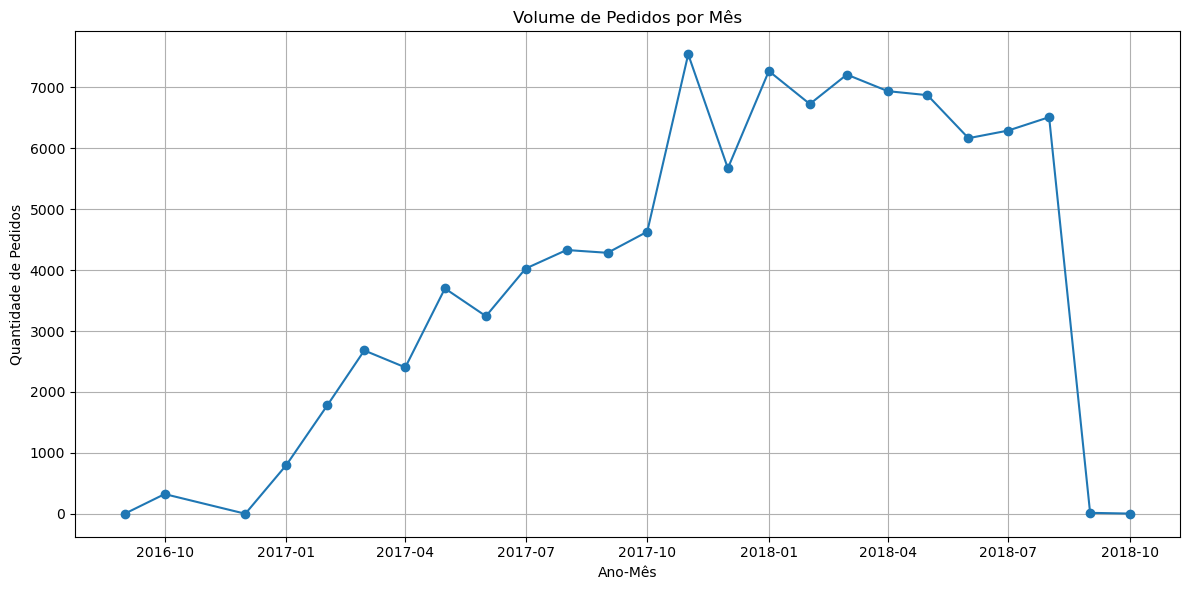

In [262]:
query = """
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS ano_mes,
    COUNT(order_id) AS volume_pedidos
FROM orders
GROUP BY ano_mes
ORDER BY ano_mes;
"""

df_volume_mensal = pd.read_sql_query(query, conn)
# converte o tipo do ano e mes que atualmente em string, para datetime.
df_volume_mensal['ano_mes'] = pd.to_datetime(df_volume_mensal['ano_mes'])

plt.figure(figsize=(12, 6))
# Plota uma linha contínua com pontos marcando os volumes mensais dos pedidos daquele mês.
plt.plot(df_volume_mensal['ano_mes'], df_volume_mensal['volume_pedidos'], marker='o')
# Define o titulo do gráfico
plt.title('Volume de Pedidos por Mês')
# Define o nome do eixo X
plt.xlabel('Ano-Mês')
# Define o nome do eixo Y
plt.ylabel('Quantidade de Pedidos')
# ativando a grade no gráfico, linhas horizontais e verticais que ajudam a visualizar melhor os valores e a interpretar o gráfico.
plt.grid(True)
# ajustando os espaçamentos do gráfico para que os elementos (títulos, eixos, legendas) não fiquem cortados ou sobrepostos.
plt.tight_layout()
# exibindo o gráfico.
plt.show()

## Resposta: 
Sim há sazonalidade. 
1. Existe um aumento significativo no volume de vendas entre Novembro até Janeiro, geralmente por causa do Black Friday e compras de fim de ano, como: Natal e Ano Novo;
2. Em seguida, entre fevereiro e março, ocorre outra alta, acredito que esteja relacionado ao periodo de férias escolares;
3. Porem entre março e abril, podemos observar uma queda das vendas, possivelmente devido a normalização do consumo após o inicio do periodo letivo;
4. Logo após, outra queda acontece entre maio e junho repedindo a estabilização de consumo;
5. Seguindo por um novo crescimento, entre junho e agosto acredito que seja por causa das datas comemorativas como o Dia dos Namorados, São João e o inicio das ferias do meio do ano.

## Sugestões: 
1. Aumentar o estoque em periodos de alta demanda. Por que se os pedidos aumentam sempre em meses como novembro e dezembro a empresa pode preparar mais estoque para evitar produtos fora do estoque. É aconselhável antecipar compras com fornecedores em 1 a 2 meses;
2. Realizar campanhas de marketing sazonal. Aproveitar picos de interesse dos cosumidores com promoções bem direcionadas para grandes datas comemorativas é uma boa alternativa;
3. Reforçar logistica e atendimento. A alta demanda exige eficiencia nas entregas, podemos alugar galpões logisticos temporariamente e abastece-los com os principais produtos mais vendidos daquela região, assim aumentando a eficiencia das entregas, e alem disso, contratar colaboradores temporarios ou tercerizar uma empresa de atendimentos para melhorar o atendimento nessa epoca, assim melhorando o olhar do cliente em relação a empresa;
4. Realizar campanhas de venda e promoções em meses de baixa. É possivel estimular a vontade de compra dos clientes atraves de promoções, como: oferecer frete grátis, cupons de desconto e até mesmo kits promocionais;
5. Realizar alinhamento da Equipe de produtos e fornecedores: Acredito que a sazonalidade pode afetar a linha de produtos ofertada e o prazo de entrega dos produtos pelos fornecedores.

### b) Qual a distribuição do tempo de entrega dos pedidos?

Essa pergunta tem como objetivo analisar o tempo de entrega dos pedidos. 

Para isso, irei utilizar os dados da coluna: da data de envio (order_delivered_carrier_date) e data de entrega (order_delivered_customer_date) da tabela orders, para ententender a eficiencia logistica da empresa.
1. Convertir as datas (order_delivered_customer_date) e julianday(order_purchase_timestamp) do tipo string para decimal utilizando o comando julianday;
2. Realizei a subtração entre amabas para saber a diferença em dias entre a compra e a entrega do pedido;
3. Atribuir um apelido (tempo_entrega) para o valor da diferença entre as datas;
4. Apliquei o filtro somente linhas que contenham valores nas colunas de compra e entrega do pedido;
5. Apliquei outro filtro na coluna de status dos pedidos (order_status) para garantir que seja possivel analisar somente pedidos que realmente foram entregues;
6. Plotei o gráfico do tipo histograma. Pelo tempo de entrega ser uma variavel contínua que representa em dias valores, como: 5, 10, 12... e etc. Assim o histograma mostra quantos pedidos foram entregues em X dias, agrupando por periodos de tempo. Assim ajudando a enxergar de forma geral a distribuição, onde estão os picos e exceções;
7. Mostrei as estatisticas resumidas abaixo do gráfico para detalhar e facilitar mais o entendimento das informações.

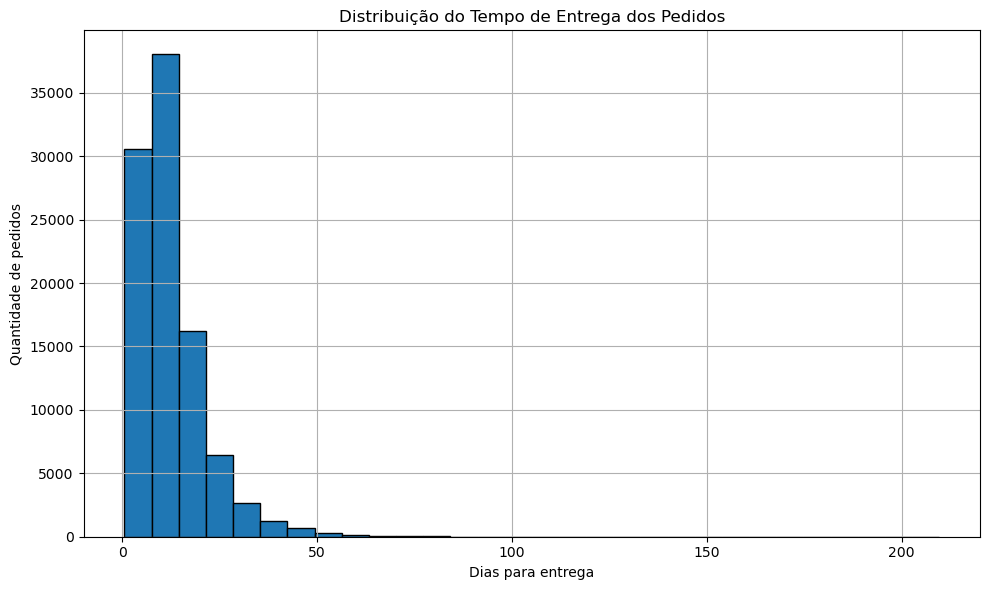

,tempo_entrega
count,96470.000000
mean,12.558217
std,9.546156
min,0.533414
25%,6.766204
50%,10.217477
75%,15.720182
max,209.628611


In [266]:
query = """
SELECT 
    julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS tempo_entrega
FROM orders
WHERE order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL
  AND order_status = 'delivered';
"""

df_entrega = pd.read_sql_query(query, conn)

plt.figure(figsize=(10, 6))
plt.hist(df_entrega['tempo_entrega'], bins=30, edgecolor='black')
plt.title('Distribuição do Tempo de Entrega dos Pedidos')
plt.xlabel('Dias para entrega')
plt.ylabel('Quantidade de pedidos')
plt.grid(True)
plt.tight_layout()
plt.show()
# Estatísticas
df_entrega.describe()

##### Interpretação das estatiticas resumidas:
Média = 12 dias --> Em média, os pedidos são entregues em cerca de 12 dias.

Mediana = 10 dias --> Metade dos pedidos leva até 11 dias para serem entregues.

Desvio padrão = 9.5 dias --> Existem variações moderadas em torno da média.

25% dos pedidos são entregues em até 10 dias.

75% dos pedidos são entregues em até 15 dias.

Máximo = 209 dias --> Um ou mais pedidos levaram até 6 meses para serem entregues (potencial outlier ou problema logístico grave).

## Resposta: 
A maioria dos pedidos é entregue entre 7 e 15 dias após a compra. No entanto, existe uma quantidade significativa de pedidos com entrega acima de 20 dias, o que pode indicar problemas logísticos ou gargalos com certos vendedores ou regiões.

## Sugestões 
1. Identificar aos outliers de entrega. É importante identificar os pedidos com tempos de entrega muito acima do normal, como: 30, 60 ou até 120 dias;
2. Responder aos outliers de entrega. Investigar esses casos de forma individual e avaliar se: o problema está relacionado a vendedores específicos,  se o pedido foi realizado em periodos criticos, como por exemplo black friday, natal e etc, se a causa foi por dificil acesso a região de entrega do produto;
3. Classificar vendedores com base na performannce de entrega. Acredito que alguns vendedores podem estar contribuindo mais para os atrasos. Então sugiro gerar relatorios mensais e assim, premiar bons vendedores com mais visibilidade e aplicar medidas corretivas em casos criticos;
4. Reforçar estrutura logistica nas regiões mais lentas. Acredito que algumas regiões possam ser de dificil acesso, assim contribuindo para entregas mais lentas. Devemos reforçar parcerias locais e reforçar rotas buscando se possivel, outros pontos logisticos estrategicos e redirecionar principar produtos vendidos daquela região no estoque;
5. Educar o cliente com tempo de entregas realmente realistas. Se a mediana de entrega for 10 dias, os clientes esperando por menos, então as vezes o problema pode não está do processo logistico, e sim na expectativa do cliente.

### c) Qual a relação entre o valor do frete e a distância de entrega?

Essa pergunta tem como objetivo verificar se existe uma correlação entre o valor do frete pago pelo cliente e a distância entre o vendedor e o cliente, usando a localização via CEP e coordenadas geográficas.

1. Irei analisar se existe correlação entre o valor do frete pago (freight_value) e a distância entre o vendedor e o cliente, o que pode revelar a eficiência (ou ineficiência) da logística do e-commerce;
2. Obter as coordenadas geográficas de cliente e vendedor através do geolocation;
3. Relacionar essa distância com o freight_value (frete) da tabela order_items;
4. Plotar gráfico de dispersão para identificar padrão ou correlação.

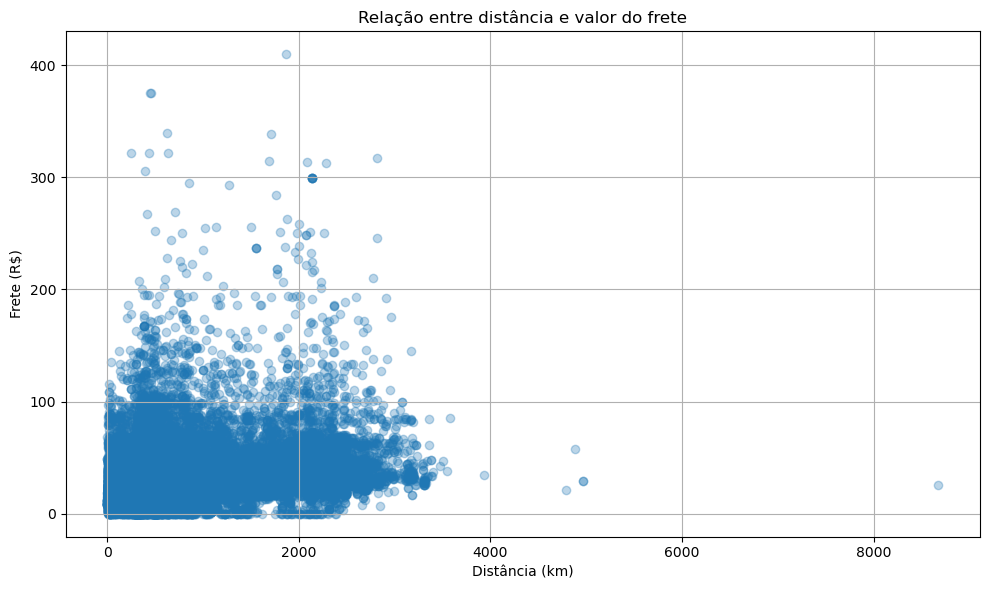

In [271]:
import numpy as np

# Calcula a coordenada média de cada zip_code_prefix
geo_zip = df_geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
geo_zip.columns = ['zip_code_prefix', 'lat', 'lng']

df_customers_coord = df_customers.merge(
    geo_zip,
    left_on='customer_zip_code_prefix',
    right_on='zip_code_prefix',
    how='left'
)
df_customers_coord.rename(columns={'lat': 'customer_lat', 'lng': 'customer_lng'}, inplace=True)
df_customers_coord.drop(columns=['zip_code_prefix'], inplace=True)

df_sellers_coord = df_sellers.merge(
    geo_zip,
    left_on='seller_zip_code_prefix',
    right_on='zip_code_prefix',
    how='left'
)
df_sellers_coord.rename(columns={'lat': 'seller_lat', 'lng': 'seller_lng'}, inplace=True)
df_sellers_coord.drop(columns=['zip_code_prefix'], inplace=True)

# Função para calcular distância geográfica
def distancia(lat1, lng1, lat2, lng2):
    R = 6371  # raio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lng2 - lng1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Combinar pedidos com clientes e vendedores
df_full = df_order_items.merge(df_orders[['order_id', 'customer_id']], on='order_id', how='left')
df_full = df_full.merge(df_customers_coord[['customer_id', 'customer_lat', 'customer_lng']], on='customer_id', how='left')
df_full = df_full.merge(df_sellers_coord[['seller_id', 'seller_lat', 'seller_lng']], on='seller_id', how='left')

# Calcular a distância em km entre o seller e o cliente
df_full['distancia_km'] = distancia(
    df_full['customer_lat'], df_full['customer_lng'],
    df_full['seller_lat'], df_full['seller_lng']
)

# Visualizar a relação entre distância e valor do frete
plt.figure(figsize=(10, 6))
plt.scatter(df_full['distancia_km'], df_full['freight_value'], alpha=0.3)
plt.title('Relação entre distância e valor do frete')
plt.xlabel('Distância (km)')
plt.ylabel('Frete (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Resposta:
Há uma relação positiva entre distancia e valor do frete, quanto maior a distância entre o vendedor e o cliente, maior tente a ser o frete. No entanto, foi encontrado uma alta dispersão nos dados, com fretes elevados mesmo em distancias menores. Então, isso pode indicar que além da distancia, outros fatores influenciam no preço, como por exemplo: Peso, Categoria do Produto e Tipo de entrega.

## Sugestões:
1. Revisar a política de preços dos fretes. Muitos frestes são caros mesmo em pequenas distancias. É aconselhavel reavaliar os critérios de cobrança do frete, como: aplicar tarifas por categoria de produto, por peso ou região;
2. Classificar os fretes por região e produto. Produtos leves em curtas distancias não deveriam gerar fretes altos. Criar faixas de preços por categoria junto com o raio geografico de entrega, assim reduzindo variações sem justificativas;
3. Renegociar rotas com transportadoras. Fretes elevados podem estar ligados a contratos logisticos ineficientes. Avaliar regiões com maior voolume e negociar tabelas especificas com as transportadoras;
4. Anexar novos centros de distribuição em regiões com alto volume de vendas para reduzir o custo do frete.

### d) Quais são as categorias de produtos mais vendidas em termos de faturamento?

Vamos analisar quais categorias de produto geram mais receita, com base no faturamento tota (soma dos preços dos produtos vendidos).

##### Para isso realizei:
1. A soma do valor total vendido por produto da coluna (price), atraves da tabela order_items;
2. Left Join entre order_items e products usando o product_id, para conseguir pegar a categoria dos produtos atraves da coluna product_category_name que não esta na tabela order_items;
3. Agrupei a categoria, para poder somar o faturamento de cada grupo;
4. Ordenei a consulta como ordem descrescente, da mais lucrativa para a menos;
5. Limitei o resultado para 10, para realizar as Top 10 produtos mais vendidos pelo e-commerce;
6. Utilizei o gráfico do tipo barras horizontas, por facilitar a leitura de rotulos com texto longos do eixo Y, isso pode ser visto no nome das categorias, alem disso, permite uma melhor visualização decrescente dos dados, assim deixando comparação fica mais intuitiva entre os valores.

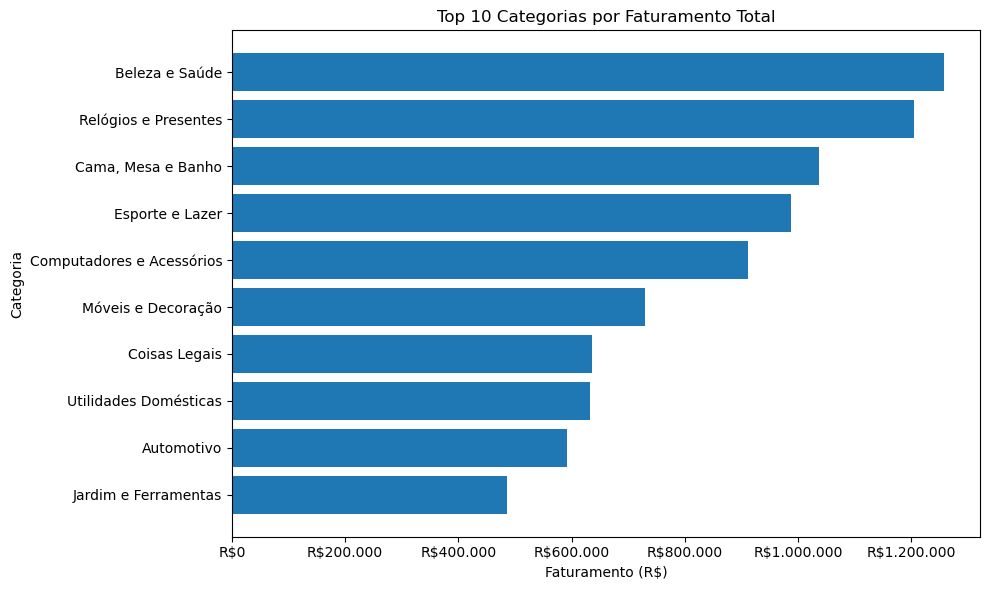

In [278]:
import matplotlib.ticker as ticker

query = """
SELECT 
    pct.product_category_name_english AS categoria,
    ROUND(SUM(oi.price), 2) AS faturamento_total
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct 
    ON p.product_category_name = pct.product_category_name
GROUP BY categoria
ORDER BY faturamento_total DESC
LIMIT 10;
"""

df_faturamento = pd.read_sql_query(query, conn)

# Dicionário de tradução para as 10 categorias mais vendidas
traducao_categorias = {
    'health_beauty': 'Beleza e Saúde',
    'watches_gifts': 'Relógios e Presentes',
    'bed_bath_table': 'Cama, Mesa e Banho',
    'sports_leisure': 'Esporte e Lazer',
    'computers_accessories': 'Computadores e Acessórios',
    'furniture_decor': 'Móveis e Decoração',
    'cool_stuff': 'Coisas Legais',
    'housewares': 'Utilidades Domésticas',
    'auto': 'Automotivo',
    'garden_tools': 'Jardim e Ferramentas'
}

# Aplica a tradução no DataFrame
df_faturamento['categoria_pt'] = df_faturamento['categoria'].map(traducao_categorias)

# Plot com os nomes traduzidos e valores em reais
plt.figure(figsize=(10, 6))
plt.barh(df_faturamento['categoria_pt'], df_faturamento['faturamento_total'])
plt.xlabel('Faturamento (R$)')
plt.ylabel('Categoria')
plt.title('Top 10 Categorias por Faturamento Total')
plt.gca().invert_yaxis()

# Formatar eixo X com valores em reais
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'.replace(',', '.')))

plt.tight_layout()
plt.show()

## Resposta:
Com base nos dados das vendas do produto, foi calculado o faturamento total por categoria de produto, somando o valor de todos os itens vendidos. Eu categorizei as top 10 com maior faturamento como visto no grafico acima. E o resultato foi que as top 5 são: 1. Beleza e Saúde, 2. Relógios e presentes, 3. Cama, Mesa e Banho, 4. Esporte e Lazer, 5. Computadores e Acessórios.

## Sugestões:
1. Focar em campanhas promocionas nas Top 10 categorias, por terem um alto giro de aceitação. Podendo assim potencializar ainda mais as vendas, através de promoções e cupons;
2. Explorar mais categorias que tenham possiveis crescimentos. As categorias entre 6ª e 10ª posição (Moveis, Utilidades Domesticas, Jardim e Ferramentas e etc.), tem espaço para crescer. Então é ideal investir em anuncios direcionados, parcerias com fornecedores e recomendação inteligente no proprio site do e-commerce.

### e) Quais estados brasileiros possuem o maior valor médio de pedido?
Essa pergunta ajuda a entender onde estão os clientes com maior poder de compra, ou quais regiões fazem compras com ticket medio mais rapido.
Para isso é necessario:
1. Somar o valor total de cada pedido da tabela order_items;
2. Calcular a media por pedido;
3. Realizar um Join entre as tabelas orders e custormers para saber de qual estado o pedido foi realizado;
4. Agrupar por estado e calcular a média do valor total dos pedidos por estados.

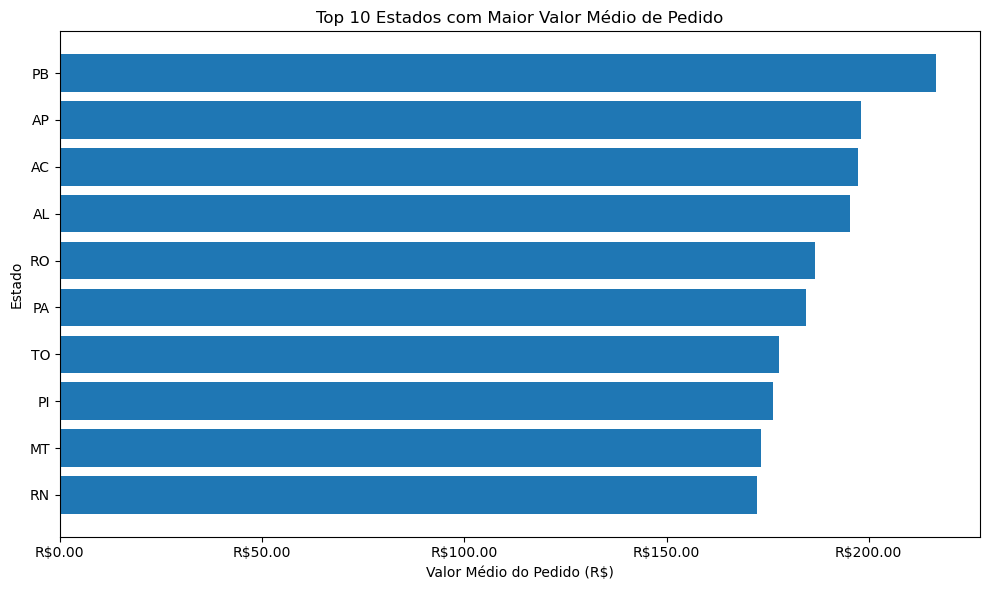

In [280]:
query = """
WITH total_por_pedido AS (
    SELECT 
        order_id,
        SUM(price) AS valor_total_pedido
    FROM order_items
    GROUP BY order_id
)

SELECT 
    c.customer_state AS estado,
    ROUND(AVG(tpp.valor_total_pedido), 2) AS valor_medio_pedido
FROM total_por_pedido tpp
JOIN orders o ON tpp.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY estado
ORDER BY valor_medio_pedido DESC
LIMIT 10;
"""

df_valor_medio = pd.read_sql_query(query, conn)

# Visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
plt.barh(df_valor_medio['estado'], df_valor_medio['valor_medio_pedido'])
plt.xlabel('Valor Médio do Pedido (R$)')
plt.ylabel('Estado')
plt.title('Top 10 Estados com Maior Valor Médio de Pedido')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'R${x:,.2f}'.replace(',', '.')))
plt.tight_layout()
plt.show()

## Resposta:
Os estados com o maior valor médio por pedido são, em ordem decrescente: Paraíba (PB), Amapá (AP), Acre (AC), Alagoas (AL) e Rondônia (RO).
Esses estados, maioria das regiões Norte e Nordeste, apresentam uma média de valor por pedido superior à média nacional, ultrapassando R$ 180,00 por compra.

## Sugestões:
1. Explorar o potencial dos estados. Investir em campanhas especificas para esses estados. Oferecendo programas de fidelidade, vantagens para carrinhos com maior valor agregado e etc;
2. Entender o perfil de consulmo regional. Verificar quais categorias são mais vendidas nos estados. Realizar uma classificação de mercado com base em comportamento de compra e valor médio;
3. Ajustar politicas de frete e logistica. Avaliar se o frete elevado esta inflando o valor do pedido;
4. Identificar oportunidades de expansão. Se a margem dos estados for boam é viavel investir em centros logisticos nessas regiões para reduzir custos e prazos de entregas.

# 3. Solução de Problemas de Negócio (25 pontos)


### 1) Análise de Retenção: Calcule a taxa de clientes recorrentes. Considere um cliente recorrente aquele que fez mais de um pedido no período analisado. Quais insights podemos extrair destes dados?
Realizei as seguintes etapas:
1. Agrupei a tabela orders atraves do seu id;
2. Contei quantos order_id cada cliente fez;
3. Utilizei python e logica boleana para criar um dataframe temporario chamado df_retenção, onde na coluna retenção se o cliente tiver realizado mais de 1 pedido, me retorna o valor true, caso contrario false;
4. Calculei os totais, contando o numero total de clientes unicos;
5. Somei a quantidade de true da coluna recorrente, isso retorna a quantidade de clientes que fizeram mais de um pedido;
6. Calculei a taxa de recorrencia dividindo a quantidade de recorrentes pelo total de clientes;
7. Plotei um grafico tipo pizza. Utilizei esse tipo por ser ideal para representar proporções de um todo, facilitando a visualização da distribuição percentual entre clientes recorrentes e não recorrentes. Ele destaca de forma clara a baixa participação de clientes fiéis, ajudando a comunicar rapidamente esse ponto crítico para áreas de marketing e retenção.

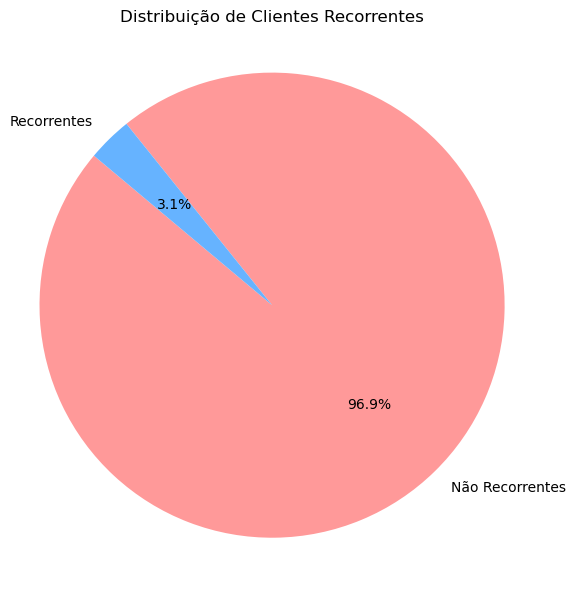

Clientes recorrentes: 2997
Total de clientes: 96096
Taxa de recorrência: 3.12%


In [300]:
query = """
SELECT 
    c.customer_unique_id,
    COUNT(o.order_id) AS total_pedidos
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id;
"""

df_retencao = pd.read_sql_query(query, conn)

# Classificar clientes como recorrentes ou não
df_retencao['recorrente'] = df_retencao['total_pedidos'] > 1

# Cálculo da taxa de clientes recorrentes
qtd_total_clientes = df_retencao.shape[0]
qtd_recorrentes = df_retencao['recorrente'].sum()
taxa_recorrencia = qtd_recorrentes / qtd_total_clientes

# Contagem de recorrentes e não recorrentes
qtd_nao_recorrentes = qtd_total_clientes - qtd_recorrentes
labels = ['Não Recorrentes', 'Recorrentes']
valores = [qtd_nao_recorrentes, qtd_recorrentes]
cores = ['#ff9999','#66b3ff']

# Criar gráfico
plt.figure(figsize=(6, 6))
plt.pie(valores, labels=labels, autopct='%1.1f%%', startangle=140, colors=cores)
plt.title('Distribuição de Clientes Recorrentes')
plt.axis('equal')  # Deixa o gráfico em forma de círculo
plt.tight_layout()
plt.show()

print(f"Clientes recorrentes: {qtd_recorrentes}")
print(f"Total de clientes: {qtd_total_clientes}")
print(f"Taxa de recorrência: {taxa_recorrencia:.2%}")


## Resposta:

Temos 2997 cliente recorrentes de um total de 96096 clientes cadastrados no e-commerce, com uma taxa de recorrência de 3.12% no periodo analisado.

#### Insights:
1. Grande parte dos clientes compram apenas uma vez. Como a taxa de recorrência está abaixo de 10%, isso indica que o e-commerce não está fidelizando seus clientes. Sendo assim, acredito que a empresa esta gastando mais para adquirir novos clientes do que para mante-los, sendo assim menos eficiente a longo prazo;
2. Falta de estrategias de retenção. Memo que a experiencia de compra seja boa, a falta de compras recorrentes sugere ausencia de estimulos pos-vendas. Sugiro investir em campanhas de remarketing, disponibilizar cupons ou descontos exclusivos para 2ª compra, iniciar programas de cashback e enviar email recorrentes para os clientes com recomendações de compras;
3. Acredito que clientes recorrentes podem ser mais lucrativos. Pois tendem a: comprar com mais frequencia, gastar mais por pedidos e confiar mais nos serviços do e-commerce. Analisar o comportamento dos clientes recorrentes pode ajudar a classifica-los pelo valor de compra de produtos, e assim, disponibilizar beneficios para estimular compras recorrentes;
4. Classificar categoriras por maior recorrencia de compras. Por exemplo: clientes de "Beleza e Saúde" podem ter recompra, por causa do uso recorrente dos produtos, diferente das categorias "Moveis" que são clientes mais pontuais;
5. Analisar o ROI de campanhas. Com a taxa de recorrência atual como linha de base, o e-commerce pode testar campanhas e medir se há taxa aumenta ao longo do tempo.

### 2) Predição de Atraso
Construção de um modelo simples para prever se um pedido será entregue com atraso.

Para isso realizei os seguintes passos:
1. Definir como atrasado o pedido que foi entregue depois da data estimada pelo sistema do e-commerce;
2. Selecionei os pedidos entregue com o status de entregues ("delivered") e as datas com valores;
3. Criei uma coluna pedido_atrasado, seguindo a logica booleana --> 1 para atrasado || 0 para dentro do prazo;
4. Criei mais 3 variaveis simples, mas com grande potencial preditivo: tempo_aprovacao(tempo entre compra e aprovação), ano_mes_compra(mes da compra para verificar sazonalidade), e customer_state(localização do cliente);
5. Preparei os 3 dados anteriores para usar Machine Learning, eixo x = tempo_aprovacao, customer_state, ano_mes_compra e no eixo y = pedido_atrasado;
6. Removi valores nulos;
7. Dividi os dados entre treino e teste. 70% para DADOS, e 30%5 para TESTE;
8. Realizei o treinamento do modelo. Utilizei Regressão Logistica por ser mais simples e interpretavel;
9. Realizei a avaliação do Modelo utilizando: A Matriz de confusão, Precisão das analises, Recision, Recall e F1-Score.

<Figure size 600x600 with 0 Axes>

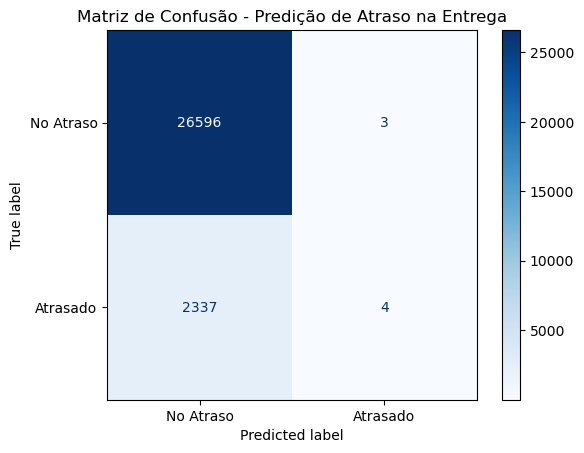

Relatório de Classificação:

              precision    recall  f1-score   support

   No Atraso       0.92      1.00      0.96     26599
    Atrasado       0.57      0.00      0.00      2341

    accuracy                           0.92     28940
   macro avg       0.75      0.50      0.48     28940
weighted avg       0.89      0.92      0.88     28940



In [316]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# definindo o que é um pedido atrasado
df_entregas = df_orders[
    (df_orders['order_status'] == 'delivered') &
    (df_orders['order_estimated_delivery_date'].notnull()) &
    (df_orders['order_delivered_customer_date'].notnull())
].copy()

df_entregas['pedido_atrasado'] = (
    pd.to_datetime(df_entregas['order_delivered_customer_date']) >
    pd.to_datetime(df_entregas['order_estimated_delivery_date'])
).astype(int)

# criando features relevantes para o modelo
df_entregas['order_purchase_timestamp'] = pd.to_datetime(df_entregas['order_purchase_timestamp'])
df_entregas['order_approved_at'] = pd.to_datetime(df_entregas['order_approved_at'])

df_entregas['tempo_aprovacao'] = (df_entregas['order_approved_at'] - df_entregas['order_purchase_timestamp']).dt.total_seconds() / 3600
df_entregas['ano_mes_compra'] = df_entregas['order_purchase_timestamp'].dt.to_period('M').astype(str)

# junção com estado do cliente
df_entregas = df_entregas.merge(df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')

# preparando o modelo
# Selecionar features
X = df_entregas[['tempo_aprovacao', 'customer_state', 'ano_mes_compra']]
y = df_entregas['pedido_atrasado']

# Transformar variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

# Remove registros com valores ausentes
X = X.dropna()
y = y.loc[X.index]  # Garante que os índices de X e y continuam alinhados
y = df_entregas['pedido_atrasado'].loc[X.index]

# dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinando o modeelo simples com regressão logistica
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

# avaliando a performance
y_pred = modelo.predict(X_test)

# Previsões
y_pred = modelo.predict(X_test)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Atraso", "Atrasado"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de Confusão - Predição de Atraso na Entrega")
plt.grid(False)
plt.show()

# Relatório de Classificação
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=["No Atraso", "Atrasado"]))

#### Interpretando as saidas da Matriz de Confusão:

Verdadeiro: Não atrasado --> Verdadeiro Negativo (TN) == Falso Positivo (FP)

Verdadeiro: Atrasado --> Falso Negatifo (FN) == Verdadeiro Positivo (TP)

## Explicação dos resultados:
O modelo obteve uma acurácia geral de 75%, equivalente a um bom desempenho para detectar pedidos atrasados, entretanto teve baixa capacidade de identificar pedidos atrasados como mostrado no relatório de classificação.

##### Recall:

Atrasado -> (apenas 0.00), ou seja, o modelo não conseguiu identificar corretamente quase nenhum atraso.

##### Support:

Houve um desequilibrio entre as classes -> (26.599 vs 2.341), influenciando diretamente na performance, favorecendo a classe dominante (Não atrasado).

##### Grafico:

A matriz de confusão informa que o modelo classifica quase tudo como (Não atrasado). Resultando em 2.335 falsos negativos (entregas atrasadas que foram previstas como não atrasadas).

## Observações:

1. Mesmo a acuracia pareça alta (75%), ela pode ser enganosa por causa do desequilibrio entre os dados;
2. O modelo atual não é confiavel para prever atrasos, o que compromete sua utilidade;
3. Mesmo assim,  a análise valida que variáveis como tempo de aprovação e sazonalidade sozinhas não explicam o atraso.

### 3) Segmentação de Clientes

Agrupamento de clientes com características semelhantes de comportamento (ex: volume de pedidos, gasto, localização) usando algoritmos de clustering não supervisionado, como o KMeans, e desenvolver insights para ações de marketing.

Para isso realizei os seguintes passos:

1. Selecioneis as variaveis que refletem nos comportamentos dos clientes, que são: qtd_pedidos (número total de pedidos feitos), total_gasto (soma total dos produtos comprados), frete_medio média de valor de frete pago, customer_frete (localização geográfica);
2. Convertir os dados categoricos em dummiers (logica booleana para modelos de machine learning), ja que modelos de ML KMeans, exigem valores numericos como entrada;
3. Apliquei o algoritmo KMeans em 4 clusters para iniciar a analise;
4. Fiz uma analise descritiva dos clusters, calculando sua media de cada variavel;
5. Plotei um grafico boxplot para observar a distribuição do valor total gasto por cluster. Optei por esse tipo de grafico por que é a melhor escolha para comparar a  distribuição de uma variavel continua, como gasto total entre diferentes classes de clusters;
6. Classifiquei os clusters: Cluster 1 -> Clientes Premium | Cluster 0 -> Clientes em crescimento | Cluster 2 -> Clientes comuns ou sazonais | Cluster 3 -> Clientes inativos ou iniciais;
7. Sugerir as seguintes estratégias de Marketing por classificações dos Clusters.

         qtd_pedidos  total_gasto  frete_medio
cluster                                       
0           1.185950   141.133008    20.484891
1           1.180868   142.337081    20.028446
2           1.174539   141.823943    20.830921
3           1.123142   176.295074    36.665821


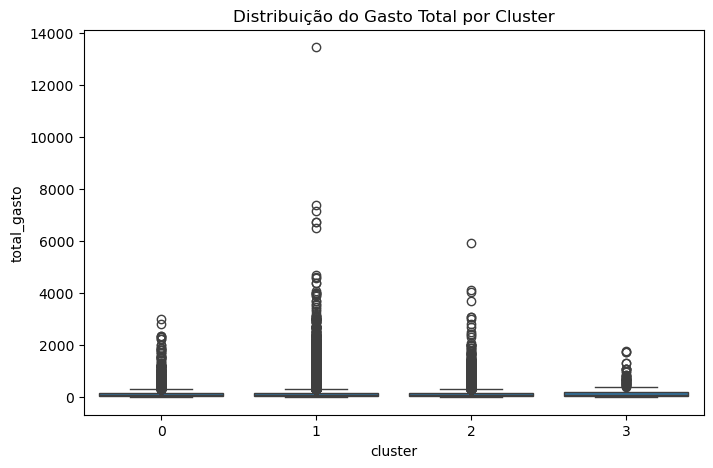

In [362]:
import os

# Definir o número de núcleos físicos do meu pc
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

query = """
SELECT 
    c.customer_unique_id,
    c.customer_state,
    COUNT(o.order_id) AS qtd_pedidos,
    SUM(oi.price) AS total_gasto,
    AVG(oi.freight_value) AS frete_medio
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_unique_id, c.customer_state;
"""

df_clientes = pd.read_sql_query(query, conn)

# Convertendo variáveis categóricas
df_cluster = pd.get_dummies(df_clientes, columns=['customer_state'], drop_first=True)

# Selecionando apenas as features numéricas
features = df_cluster.drop(columns=['customer_unique_id'])

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Agrupar e visualizar médias por cluster
df_analise = df_cluster.groupby('cluster')[['qtd_pedidos', 'total_gasto', 'frete_medio']].mean()
print(df_analise)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cluster, x='cluster', y='total_gasto')
plt.title('Distribuição do Gasto Total por Cluster')
plt.show()

## Analise Gráfica:

Podemos analisar que:

1. Cluster 1 --> Possui os clientes com o maior gato total, incluindo varios outilers com gasto acima de 5.000,00 reais;
2. Clusters 0 e 2 --> Apresentam gastos médios moderados, com outliers mais modestos;
3. Cluster 3 --> Concentra a maior parte dos clientes com menor gasto, com poucos o utliers e valores, estão abaixo de 500,00 reais.



Diante desses fatos podemos classificar os clientes da seguinte maneira:

1. Cluster 1 --> Clientes Premium: Alto gasto, poucos clientes, maior potencial de compra;
2. Cluster 0 --> Clientes em crescimento: Gasto médio, possiveis fidelidades.
3. Cluster 2 --> Clientes comuns ou sazonais: Compram esporadicamente com valor moderado;
4. Cluster 3 --> Clientes inativos ou iniciais: Gasto baixo, possivel abandono.

## Estrategicas por Clusters:

##### Cluster 1 - Clientes Premium
1. Oferecer programas de fidelidade VIP;
2. Descontos exclusivos e pré-lançamentos;
3. Consultores ou atendimento personalizado.

##### Cluster 0 – Clientes Em crescimento
1. Estimulos para aumentar o numeros de compras, como: promoções, combos e etc;
2. Incentivos progressivos de frete grátis ou cashback.

##### Cluster 2 - Clientes Sazonais
1. Ações baseadas em datas comemorativas ou épocas de alta;
2. E-mails personalizados com base em histórico de compra.

##### Cluster 3 – Clientes Inativos
1. Realizar campanhas para convida-los a comprar novamente no site;
2. Cupons de retorno, do tipo: sentimos sua falta;
3. Questionários de satisfação ou abandono. Essencial para realmente entender onde está o problema.